In [12]:
import os
import numpy as np 
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
from ast import literal_eval
from glob import glob
import pandas as pd

In [14]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical


def preprocessRawStrokes(raw_strokes):
    """ process raw input strokes from .csv file.
    Stack all stroke vector to a Nx3 array. c_stroke[:,2] indicates if this is a start of a new stroke vector
    with 1 or 2. Then make all strokes the same length
    """
    stroke_vec = literal_eval(raw_strokes) # read stroke string vector to list
    
    # unwrap the list
    in_strokes = [(xi, yi, i) for i, (x, y) in enumerate(stroke_vec) for xi, yi in zip(x,y)]    
    c_strokes = np.stack(in_strokes)

    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1] + np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    
    # make all strokes same length by padding the strokes with zero after
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=196, 
                         padding='post').swapaxes(0, 1)


def read_batch(paths, samples=5, 
               start_row=0,
               n_rows=1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for path in paths:
        c_df = pd.read_csv(path, nrows=n_rows, skiprows=start_row)
        c_df.columns=['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].map(preprocessRawStrokes)
#     full_df = full_df.sample(frac=1)  # shuffle data
    return full_df.sample(frac=1)


def read_full_csv(paths, train_split=0.75, valid_split=0.15, test_split=0.15):
    
    train_out_df_list = []
    valid_out_df_list = []
    test_out_df_list = []
    
    for path in paths:
        df = pd.read_csv(path)
        valid_df, test_df, train_df = np.split(df, [int(valid_split*len(df)), int((valid_split+test_split)*len(df))])
        
        train_df.columns = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
        valid_df.columns = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
        test_df.columns = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

        train_out_df_list += [train_df[['drawing', 'word']]]
        valid_out_df_list += [valid_df[['drawing', 'word']]]
        test_out_df_list += [test_df[['drawing', 'word']]]
        
    train_full_df = pd.concat(train_out_df_list)
    valid_full_df = pd.concat(valid_out_df_list)
    test_full_df = pd.concat(test_out_df_list)
    
    train_full_df['drawing'] = train_full_df['drawing'.map(preprocessRawStrokes)]
    valid_full_df['drawing'] = valid_full_df['drawing'.map(preprocessRawStrokes)]
    test_full_df['drawing'] = test_full_df['drawing'.map(preprocessRawStrokes)]
    
    return train_full_df.sample(frac=1), valid_full_df.sample(frac=1), test_full_df.sample(frac=1)

In [19]:
def generateDf(n_train, n_valid, n_test, n_strokes, path, debug=True):
    """ for each .csv file randomly sample 750 training instances for each csv file, 
    75 valid instances, and 50 test instances """
    
    if debug:
        train_args = dict(samples=n_train, start_row=0, n_rows=int(n_train*1.5), paths=path)
        valid_args = dict(samples=n_valid, start_row=train_args['n_rows']+1, n_rows=n_valid+25, paths=path)
        test_args = dict(samples=n_test, start_row=valid_args['n_rows']+train_args['n_rows']+1, 
                         n_rows=n_test+25, paths=path)
        train_df = read_batch(**train_args)
        valid_df = read_batch(**valid_args)
        test_df = read_batch(**test_args)
    else:
        train_df, valid_df, test_df = read_full_csv(path)

    word_encoder = LabelEncoder()
    word_encoder.fit(train_df['word'])
    print(train_df['word'])

#     print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))
    return train_df, valid_df, test_df, word_encoder

In [20]:
def getXYfromDf(df, word_encoder):
    """ Generate feature x and label y for input dataframe 
    """
    x = np.stack(df['drawing'], axis=0)
    y = to_categorical(word_encoder.transform(df['word'].values))
    return x, y

In [21]:
def demo():
    """ demonstarte how a pic made up of stroke vectors
    Each stroke_idx represents a stroke
    """
    base_dir = '/Volumes/JS/QuickDraw'
    test_path = os.path.join(base_dir, 'test_simplified.csv')
    all_train_paths = glob(os.path.join(base_dir, 'train_simplified', '*.csv'))
#     cols = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
    train_df, valid_df, test_df, word_encoder = generateDf(n_train=75, n_valid=7, n_test=5, 
                                                       n_strokes=196, path=all_train_paths, debug=True)
    x_train, y_train = getXYfromDf(train_df, word_encoder)
    print(y_train[0])
    x_valid, y_valid = getXYfromDf(valid_df, word_encoder)
    x_test, y_test = getXYfromDf(test_df, word_encoder)

    fig, m_axs = plt.subplots(3, 3, figsize=(16, 16))
    rand_idxs = np.random.choice(range(x_train.shape[0]), size = 9)

    for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
        test = x_train[c_id]
        test = test[test[:,2] > 0, :]  # when the stroke index=0 means it's invalid generate by padding 0
        stroke_idx = np.cumsum(test[:,2] - 1)
        for i in np.unique(stroke_idx):   # visualize each stroke vector
            c_ax.plot(test[stroke_idx==i,0], np.max(test[:,1]) - test[stroke_idx==i,1], '.-')
#         c_ax.axis('off')   # display axis or not
        c_ax.set_title(word_encoder.classes_[np.argmax(y_train[c_id])])

68                    lipstick
26     The Great Wall of China
37                     snowman
107                 blackberry
0                traffic light
23                   ice cream
32                      rabbit
111                      angel
64                  strawberry
111                  firetruck
41                   microwave
3                         moon
17                 spreadsheet
14                    trombone
75                    hospital
38                        shoe
80                    passport
42                      shorts
76                        hand
34                        cake
0                       finger
57                      shorts
66                        harp
66                    squiggle
103                   scissors
85                  sea turtle
44                       shark
22                     snowman
41                    kangaroo
88                        belt
                ...           
32                       snail
1       

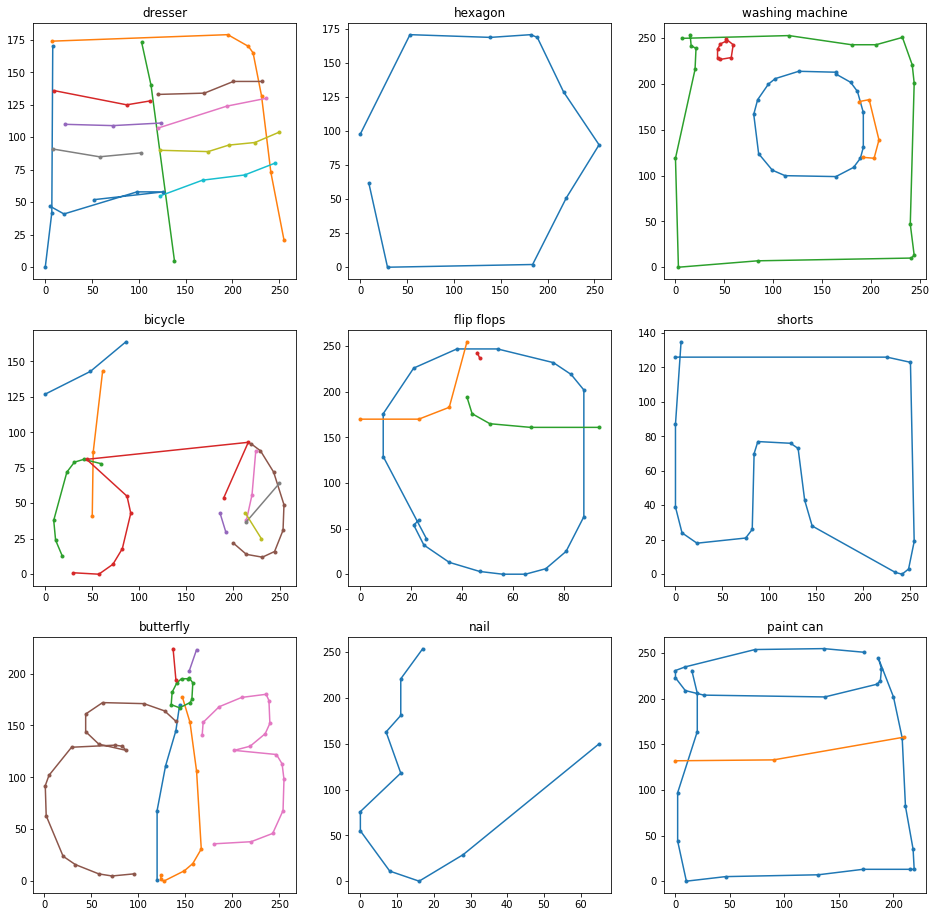

In [22]:
demo()